In [33]:
import rdutil
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [34]:
N = 10000
fs = 1e5
scenarioNUM = 1

# generate scenario
nn, nn2 = rdutil.genscenario(N, fs, scenarioNUM)

t = np.arange(N)/fs

In [35]:
# general parameters / mainly for slow time RDmap (Algorithm 3)
bs = 256  # batch size
overlap = 128  # corresponds to maximum timeshift
nbatches = int(np.floor((len(nn)-overlap)/bs)) # number of batches


In [36]:
def xcorr(x, y):
    rxy = signal.correlate(x, y, mode='full')
    lags = np.arange(-len(x)+1, len(x))
    return lags, rxy

In [37]:
# Algorithm 1:

# simple correlation using xcorr and fft
# note: both should give the same result, however
# the fft version is faster

lags, rxx = xcorr(nn, nn2)
# [fig, ax] = plt.subplots(2, 1, figsize=(10,5))
# ax[0].plot(lags, abs(rxx))
# ax[1].plot(abs(np.fft.ifft(np.fft.fft(nn) * np.conj(np.fft.fft(nn2)))))

# In the plot we expect that the maximum correlation will occur
# at the time lag which nn2 is compared to nn

# however, as we also did a frequency shift, this may not be as obvious
# as it normally should be.

Text(0, 0.5, 'Doppler (Hz)')

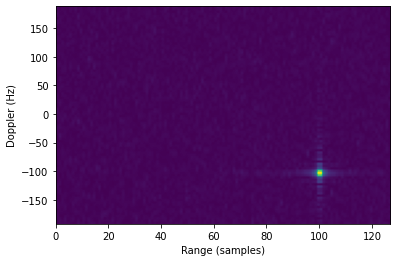

In [38]:
# Algorithm 2:
# a range doppler map (correlation in both time and frequency)
# using the fft correlation presented above.

fmap = np.arange(-(bs*0.75), bs*0.75, 4)  # select some frequency bins

rdmapX = np.zeros((len(fmap), len(nn)), dtype=complex)
# nn2 is a time+frequency shifted version of nn (done in genscenario)
nn2F = np.conj(np.fft.fft(nn2)) 

# for each frequency offset, calculate the time correlation
for fi in range(len(fmap)):
    f = fmap[fi]
    nnf = nn * np.exp(1j*2*np.pi*-f*t)

    # fft correlation in Algorithm 1
    rdmapX[fi,:] = np.fft.ifft(np.fft.fft(nnf) * nn2F) 

# figure of RDMAP made using traditional FFT
gridx = np.arange(0, overlap)
gridy = fmap

# we need to truncate the time index to only the first 128 samples
# even though the correlation is calculated over all 10000 samples
# most of them are discarded.

rdmapXTRUNC = rdmapX[:, 1:overlap]  # only need the first 'overlap' samples
plt.imshow(np.abs(rdmapXTRUNC), extent=[np.min(gridx), np.max(gridx), np.min(gridy), np.max(gridy)], aspect='auto')
plt.xlabel('Range (samples)')
plt.ylabel('Doppler (Hz)')
# plt.savefig('fullrdmap.png', dpi=360)

# we expect a high intensity dot at the frequency and time shifted
# created in genscenario funtion in rdutil.py 

In [39]:
fmap

array([-192., -188., -184., -180., -176., -172., -168., -164., -160.,
       -156., -152., -148., -144., -140., -136., -132., -128., -124.,
       -120., -116., -112., -108., -104., -100.,  -96.,  -92.,  -88.,
        -84.,  -80.,  -76.,  -72.,  -68.,  -64.,  -60.,  -56.,  -52.,
        -48.,  -44.,  -40.,  -36.,  -32.,  -28.,  -24.,  -20.,  -16.,
        -12.,   -8.,   -4.,    0.,    4.,    8.,   12.,   16.,   20.,
         24.,   28.,   32.,   36.,   40.,   44.,   48.,   52.,   56.,
         60.,   64.,   68.,   72.,   76.,   80.,   84.,   88.,   92.,
         96.,  100.,  104.,  108.,  112.,  116.,  120.,  124.,  128.,
        132.,  136.,  140.,  144.,  148.,  152.,  156.,  160.,  164.,
        168.,  172.,  176.,  180.,  184.,  188.])

Text(0, 0.5, 'Doppler (Hz)')

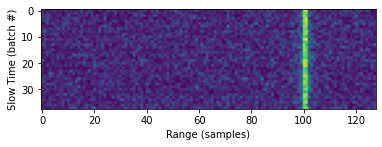

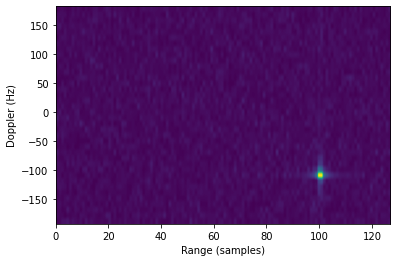

In [40]:
# Algorithm 3 (FFT in batches):

# To avoid the problem of discarding so many samples. but still getting the
# benefits of "integration time" we present a RD map made using a slow time
# transform

stmap = np.zeros((nbatches,overlap), dtype=complex)

for si in range(nbatches):
    # reference signal
    sig1 = nn[si*bs: (si+1)*(bs)]
    sig1 = np.concatenate((sig1, np.zeros(overlap)), axis=0) # increase the lengh of sig1 by overlap

    # surveillance signal
    sig2 = nn2[si*bs: (si+1)*(bs) + overlap]

    # cross correlation
    xc = np.fft.ifft(np.fft.fft(sig1) * np.conj(np.fft.fft(sig2)))
    stmap[si, :]  = xc[0:overlap]

# plot the slow time correlation
plt.figure()
plt.imshow(np.abs(stmap))
plt.xlabel('Range (samples)')
plt.ylabel('Slow Time (batch #)')

# if we take the fft at range of 100, we can get the Doppler
# plt.figure()
# plt.plot(abs(np.fft.fft(stmap[:,100])))

# next step is to perform the fft for each column (each time delay) of of the slow time map
stRDmap = np.zeros((nbatches, overlap), dtype=complex)
for ri in np.arange(overlap):
	stRDmap[:,ri] = np.fft.fftshift(np.fft.fft(stmap[:,ri]))

plt.figure()
sdata = np.shape(stRDmap)
gridx = np.arange(0, sdata[1])
gridy = (np.arange(0, nbatches)/nbatches - 0.5) *2*bs*0.75

plt.imshow(np.abs(stRDmap), extent=[np.min(gridx), np.max(gridx), np.min(gridy), np.max(gridy)], aspect='auto')
plt.xlabel('Range (samples)')
plt.ylabel('Doppler (Hz)')

# note the plot looks similar to the previous one, however it is much faster
# due to less discarded data.

# However, it does have a little less frequency resolution, due to the number of batches selected.
